# オッズの予測精度評価
人気順の上位3位が、実際に3位以内に入る可能性のモデルの精度評価。このスコアを超えない限り、オッズ通りに買った方が有利ということになる。

In [1]:
# Resultモデルをデータフレームに変換
# Getting Data
from umap.uhelper import pd_result
cols = ["rank", "odor"]
df = pd_result(cols, True)

In [2]:
import numpy as np

# 目的変数の作成（3位以内ならFalse（ゼロ）、それ以外はTrue（1））
df["top3"] = np.where(df["rank"]<=3, False, True)
df["odor3"] = np.where(df["odor"]<=3, False, True)

# 不要データの削除
df = df.drop(["rank", "odor"], axis=1)

             precision    recall  f1-score   support

      False       0.53      0.52      0.52     29590
       True       0.87      0.87      0.87    108014

avg / total       0.80      0.80      0.80    137604

複勝馬の的中率（Recall）: 0.517
購入馬券の的中率（Precision）: 0.528


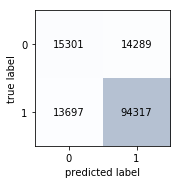

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(df.top3, df.odor3))
tp, fn, fp, tn = confusion_matrix(df.top3, df.odor3).ravel()
print('複勝馬の的中率（Recall）: {:.3f}'.format(tp / (tp + fn)))
print('購入馬券の的中率（Precision）: {:.3f}'.format(tp / (tp + fp)))

# Confusion Matrixを使った精度評価
cnf_matrix = confusion_matrix(df.top3, df.odor3)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.show()

# Sample Prediction Model Creation

In [4]:
# レース結果（出走結果のあるデータを抽出）
from umap.uhelper import pd_result
cols = ["rank", "sex", "age", "odds"]
df = pd_result(cols, True)
#df.info()

In [5]:
import numpy as np
import pandas as pd

# 性別データのダミー変数化
dmy_sex = pd.get_dummies(df.sex)
df = pd.concat([df, dmy_sex], axis=1)
df = df.drop("sex", axis=1)
df = df.rename(columns={"セ": "gelding", "牝": "female", "牡": "male"})

# 目的変数の作成（3位以内ならゼロ、それ以外は1）
df["top3"] = np.where(df["rank"]<=3, 0, 1)

# 不要データの削除
df = df.drop("rank", axis=1)
df.head()

,age,odds,gelding,female,male,top3
0,3,12.0,0,1,0,0
1,3,5.1,0,0,1,0
2,3,1.5,0,0,1,0
3,3,9.8,0,0,1,1
4,3,18.0,0,0,1,1


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# データの標準化
sc = StandardScaler()
df_std = sc.fit_transform(df.drop("top3", axis=1))
# データの分割
X = pd.DataFrame(df_std)
y = df.top3
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
# 学習（時間がかかります）
from sklearn.svm import SVC
from sklearn import linear_model, ensemble
clf = SVC(kernel="rbf", class_weight="balanced")
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

             precision    recall  f1-score   support

          0       0.38      0.83      0.52      7426
          1       0.93      0.63      0.75     26975

avg / total       0.81      0.67      0.70     34401

複勝馬の的中率（Recall）: 0.831
購入馬券の的中率（Precision）: 0.383


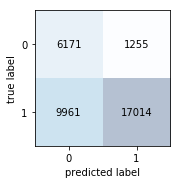

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

print(classification_report(y_test, y_pred))
recall = round(tp / (tp + fn), 3)
precision = round(tp / (tp + fp), 3)
print("複勝馬の的中率（Recall）: " + str(recall))
print("購入馬券の的中率（Precision）: " + str(precision))

# Confusion Matrixを使った精度評価
cnf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.show()

In [9]:
# モデルの保存
import pickle

model_name = "svc_v1"

p = Pmodel()
p.title = model_name
p.model_bin = clf
p.method = "classification"
p.columns = cols
p.recall = recall
p.precision = precision
p.note = "class_weight='balanced'"
p.save()

Pmodel.objects.filter(title=model_name).values("title", "method", "recall", "precision", "note")

<QuerySet [{'title': 'svc_v1', 'method': 'classification', 'recall': 0.831, 'precision': 0.383, 'note': "class_weight='balanced'"}]>

## Model Execution

In [2]:
# レース結果（出走結果のあるデータを抽出）
from umap.uhelper import pd_result
cols = ["key", "sex", "age", "odds"]
df = pd_result(cols, False)
#df.info()

In [3]:
import numpy as np
import pandas as pd

# 性別データのダミー変数化
dmy_sex = pd.get_dummies(df.sex)
df = pd.concat([df, dmy_sex], axis=1)
df = df.drop("sex", axis=1)
df = df.rename(columns={"セ": "gelding", "牝": "female", "牡": "male"})
#df.head()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# データの標準化
sc = StandardScaler()
df_std = sc.fit_transform(df.drop("key", axis=1))
# データの分割
X = pd.DataFrame(df_std)
y_key = df.key

In [5]:
# モデルのロード
p = Pmodel.objects.get(pk="svc_v1")
clf = p.model_bin

# モデルの適用
y = clf.predict(X)
y_pred = pd.Series(y)

In [6]:
# データセットとの結合
rds = pd.concat([y_pred, y_key], axis=1)
rds = rds.rename(columns={0:"expect"})
rds = rds.set_index("key")

# True/Falseを逆転（Pythonとsciki-learnの0,1が逆のため）
rds["expect"] = np.where(rds["expect"]==0, True, False)

In [7]:
# 予測データの書き込み
for index, row in rds.iterrows():
    result = Result.objects.get(pk=index)
    try:
        exp = Expect.objects.get(pk=result)
    except Expect.DoesNotExist:
        exp = Expect()
    exp.result = result
    exp.svc_v1 = row.expect
    exp.save()